線形モデルを試す：
著者：Alexandru Papiu（@ apapiu、GitHub）

このノートブックの一部を独自のスクリプトで使用する場合は、何らかのクレジットを与えてください（たとえば、これに戻るリンク）。 ありがとう！

xgboostにはいくつかの素晴らしいスクリプトが既にあるので、もっと簡単なものを試してみると思っていました。それは、正規化された線形回帰モデルです。 驚くべきことに、機能エンジニアリングがほとんどなくても非常にうまく機能します。 重要な点は、ほとんどの変数が歪んでいるため、数値変数をlog_transformすることです。

https://www.kaggle.com/apapiu/regularized-linear-models

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data=pd.concat((train.loc[:,"MSSubClass":"SaleCondition"],
                   test.loc[:,"MSSubClass":"SaleCondition"]))

データの前処理：

ここでは派手なことは何もしません：

まず、log（feature + 1）を使用して、歪んだ数値フィーチャを変換します。これにより、フィーチャがより正常になります。

カテゴリー機能のダミー変数を作成する

数値の欠損値（NaN）をそれぞれの列の平均で置き換えます

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EF83B95288>,
      dtype=object)

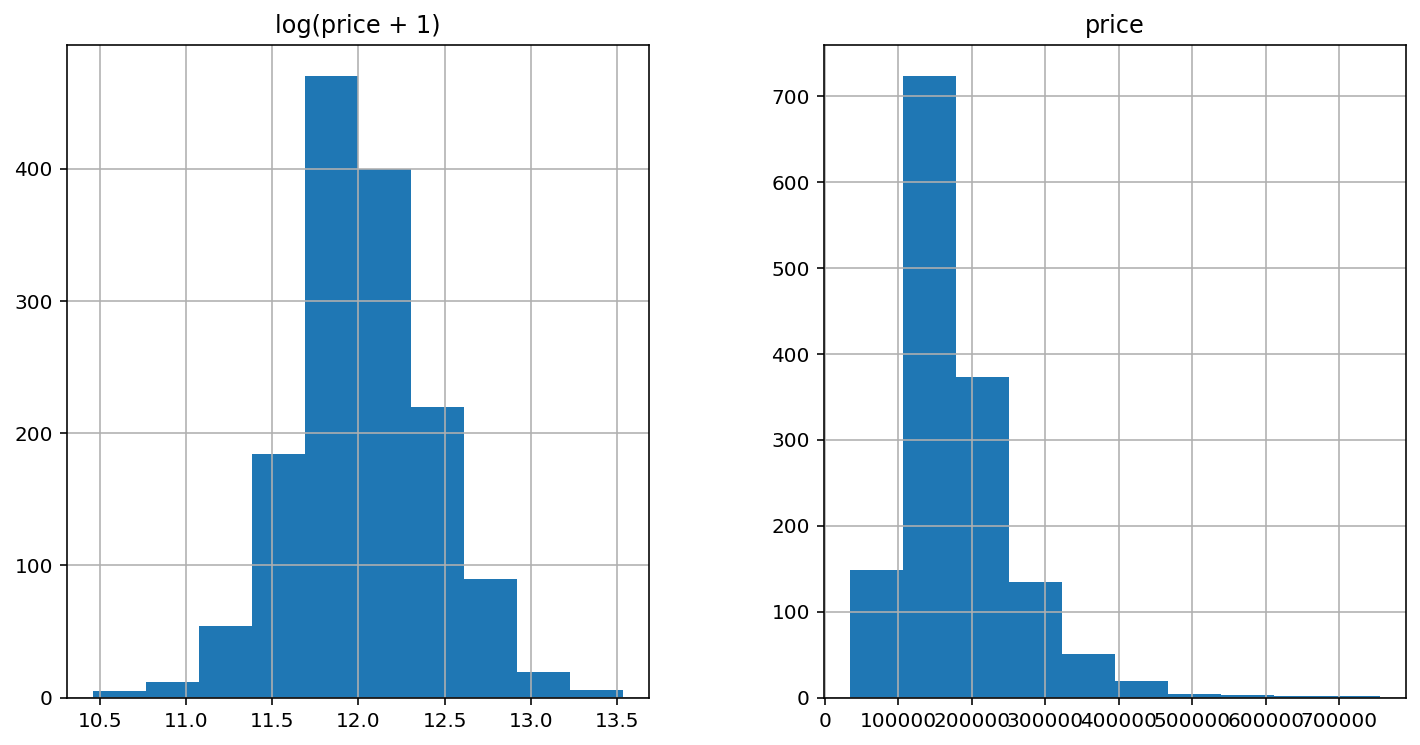

In [5]:
matplotlib.rcParams["figure.figsize"]=(12.0,6.0)
prices=pd.DataFrame({"price":train["SalePrice"],"log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
train["SalePrice"]=np.log1p(train["SalePrice"])
numeric_feats=all_data.dtypes[all_data.dtypes!="object"].index

skewed_feats=train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats=skewed_feats[skewed_feats>0.75]
skewed_feats=skewed_feats.index

all_data[skewed_feats]=np.log1p(all_data[skewed_feats])

In [7]:
all_data=pd.get_dummies(all_data)

In [8]:
all_data=all_data.fillna(all_data.mean())

In [10]:
X_train=all_data[:train.shape[0]]
X_test=all_data[train.shape[0]:]
y=train.SalePrice

モデル

ここで、scikit学習モジュールの正規化線形回帰モデルを使用します。 l_1（Lasso）とl_2（Ridge）の両方の正則化を試みます。 また、相互検証rmseエラーを返す関数を定義して、モデルを評価し、最適な調整パーを選択できるようにします。

In [12]:
from sklearn.linear_model import Ridge,RidgeCV,ElasticNet,LassoCV,LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse=np.sqrt(-cross_val_score(model,X_train,y,scoring="neg_mean_squared_error",cv=5))
    return(rmse)

In [13]:
model_ridge=Ridge()

Ridgeモデルの主な調整パラメーターはalphaです。これは、モデルの柔軟性を測定する正則化パラメーターです。 正則化が高いほど、モデルが過剰適合しにくくなります。 ただし、柔軟性が失われ、データ内のすべての信号がキャプチャされない場合があります。

In [14]:
alphas =[0.05, 0.1,0.3,1,3,5,10,15,30,50,75]
cv_ridge=[rmse_cv(Ridge(alpha=alpha)).mean()
         for alpha in alphas]

Text(0, 0.5, 'rmse')

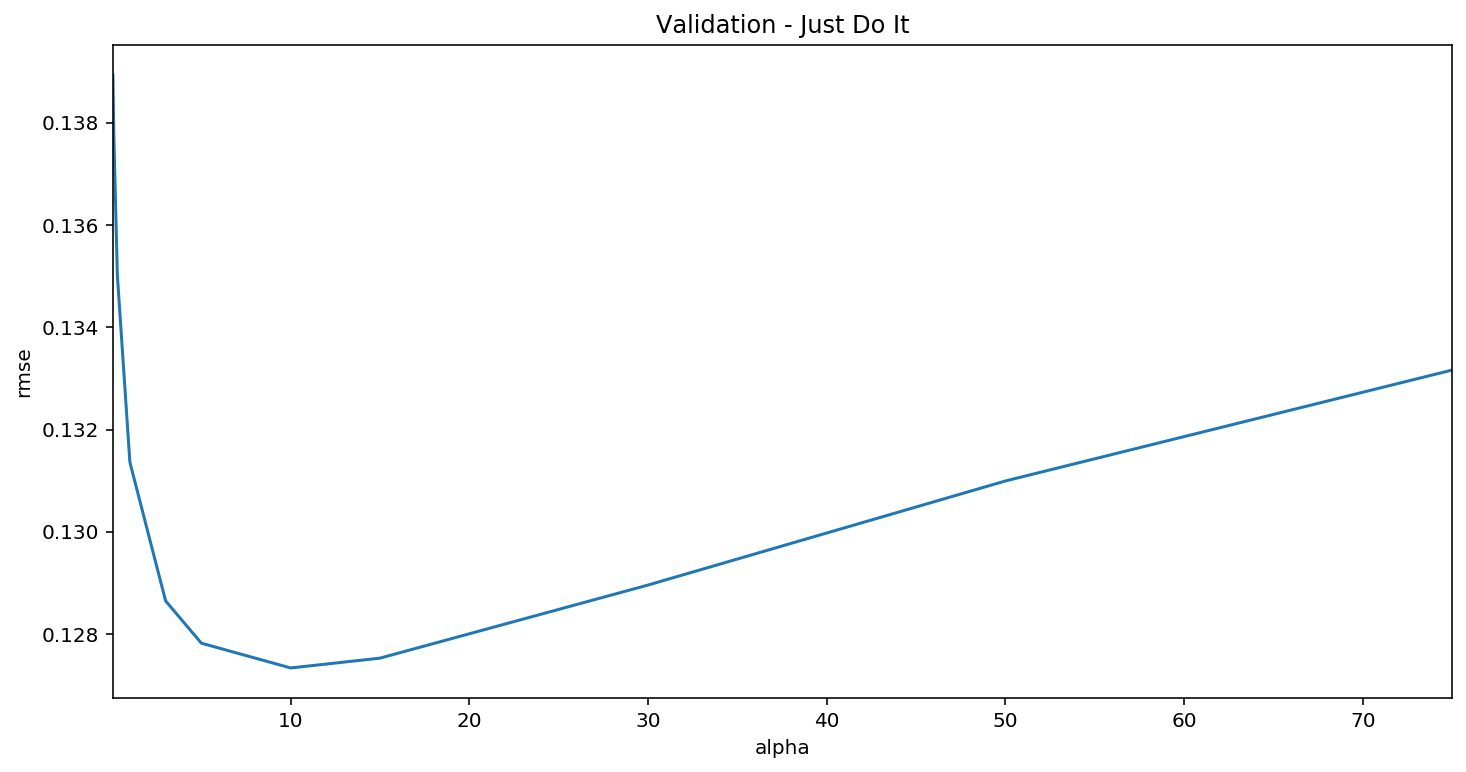

In [15]:
cv_ridge=pd.Series(cv_ridge,index=alphas)
cv_ridge.plot(title="Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

上記のU字型の曲線に注意してください。 アルファが大きすぎると、正則化が強すぎて、モデルはデータのすべての複雑さをキャプチャできません。 ただし、モデルの柔軟性が高すぎる（アルファが小さい）場合、モデルはオーバーフィットし始めます。 alpha = 10の値は、上のプロットに基づいてほぼ正しい値です。

In [16]:
cv_ridge.min()

0.12733734668670746

したがって、リッジ回帰では、約0.127のrmsleが得られます

なげなわモデルを試してみましょう。 ここでは少し異なるアプローチを行い、組み込みのLasso CVを使用して、最適なアルファを見つけます。 何らかの理由で、なげなわCVのアルファは実際には逆またはリッジのアルファです。

In [18]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [19]:
rmse_cv(model_lasso).mean()

C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

0.1231442109097745

いいね！ 投げ縄のパフォーマンスはさらに向上するため、これを使用してテストセットを予測します。 Lassoのもう1つの便利な点は、特徴選択を行うことです。重要でないと思われる特徴の係数をゼロに設定します。 係数を見てみましょう。

In [20]:
coef=pd.Series(model_lasso.coef_,index=X_train.columns)

In [21]:
print("Lasso picked"+str(sum(coef != 0))+"variables and eliminated the other"+ str(sum(coef==0))+ "variables")

Lasso picked110variables and eliminated the other178variables


お疲れ様でした。 ただし、ここで注意すべきことの1つは、選択したフィーチャが必ずしも「正しい」フィーチャではないことです。特に、このデータセットには多くの共線フィーチャがあるためです。 ここで試す1つのアイデアは、ブーストされたサンプルでLassoを数回実行し、特徴選択がどれほど安定しているかを確認することです。

最も重要な係数が何であるかを直接見ることもできます。

In [22]:
imp_coef=pd.concat([coef.sort_values().head(10),
                   coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coeff')

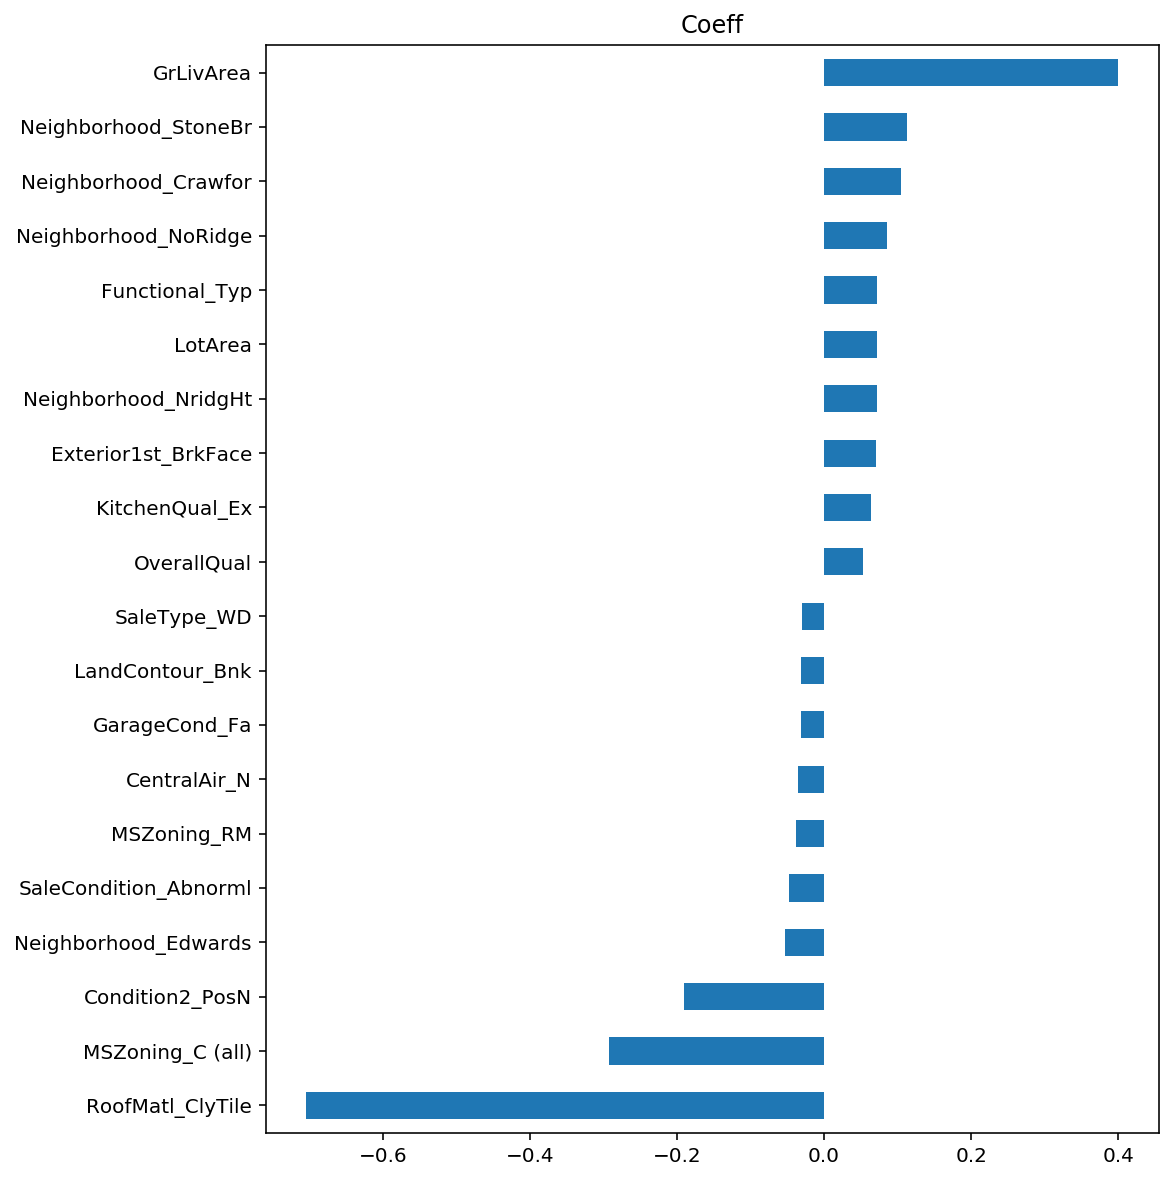

In [23]:
matplotlib.rcParams["figure.figsize"]=(8.0,10.0)
imp_coef.plot(kind="barh")
plt.title("Coeff")


最も重要な肯定的な特徴は、GrLivArea-地上の面積平方フィートです。 これは間違いなくセンスです。 その後、他のいくつかの場所と品質の機能が積極的に貢献しました。 いくつかのネガティブな特徴はあまり意味がなく、さらに調査する価値があります-それらは不均衡なカテゴリー変数に由来するようです。

また、ランダムフォレストから得られる機能の重要性とは異なり、これらはモデル内の実際の係数であるため、予測価格が正確な理由を正確に言うことができます。 ここでの唯一の問題は、ターゲットフィーチャと数値フィーチャの両方をlog_transformedしたため、実際の大きさを解釈するのが少し難しいことです。

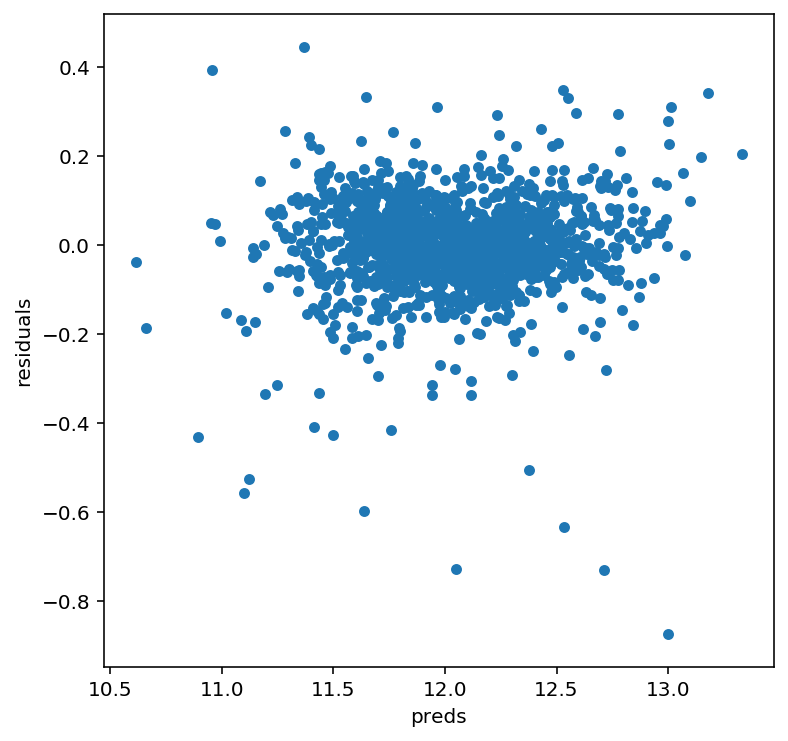

In [24]:
matplotlib.rcParams["figure.figsize"]=(6.0,6.0)

preds=pd.DataFrame({"preds":model_lasso.predict(X_train),"true":y})
preds["residuals"]=preds["true"]-preds["preds"]
preds.plot(x="preds",y="residuals",kind="scatter")

残差プロットはかなり良いように見えます。これをまとめるために、テストセットで予測し、リーダーボードで送信しましょう。

xgboostモデルの追加：
xgboostモデルを線形モデルに追加して、スコアを改善できるかどうかを確認しましょう。

In [30]:
conda install -c anaconda py-xgboost

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\yoshi\Anaconda3

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _py-xgboost-mutex-2.0      |            cpu_0          12 KB  anaconda
    ca-certificates-2019.8.28  |                0         165 KB  anaconda
    certifi-2019.9.11          |           py37_0         155 KB  anaconda
    conda-4.7.12               |           py37_0         3.0 MB  anaconda
    libxgboost-0.90            |                1         3.9 MB  anaconda
    openssl-1.1.1d             |       he774522_2         5.7 MB  anaconda
    py-xgboost-0.90            |           py37_1          80 KB  anaconda
    ------------------------------------------------------------
                                           Total:        13.0 MB

The following NEW packages will be INSTALLED:

In [33]:
import xgboost as xgb

In [35]:
dtrain=xgb.DMatrix(X_train,label=y)
dtest=xgb.DMatrix(X_test)

params={"max_depth":2,"eta":0.1}
model=xgb.cv(params,dtrain,num_boost_round=500,early_stopping_rounds=100)

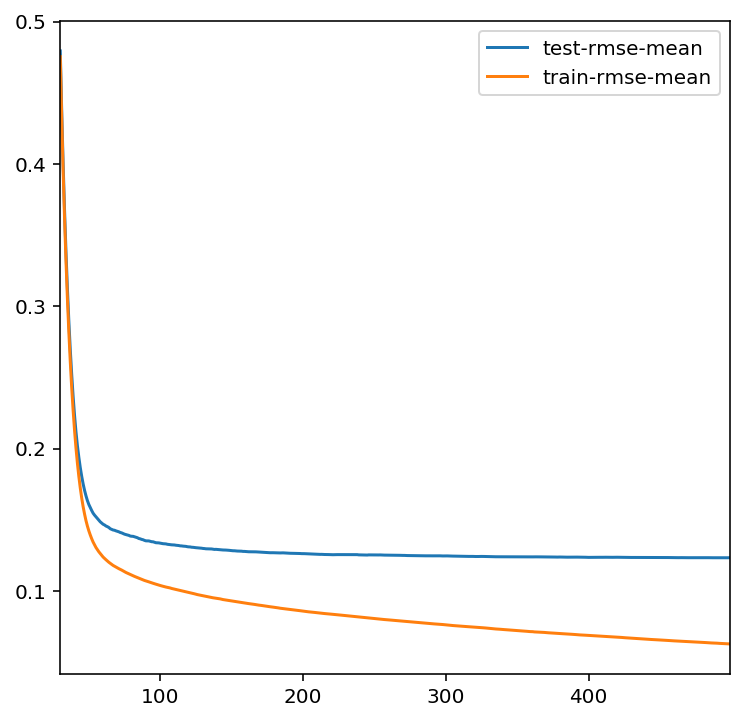

In [36]:
model.loc[30:,["test-rmse-mean","train-rmse-mean"]].plot()

In [37]:
model_xgb=xgb.XGBRegressor(n_estimators=360,max_depth=2,learning_rate=0.1)
model_xgb.fit(X_train,y)

[17:45:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
xgb_preds=np.expm1(model_xgb.predict(X_test))
lasso_preds=np.expm1(model_lasso.predict(X_test))

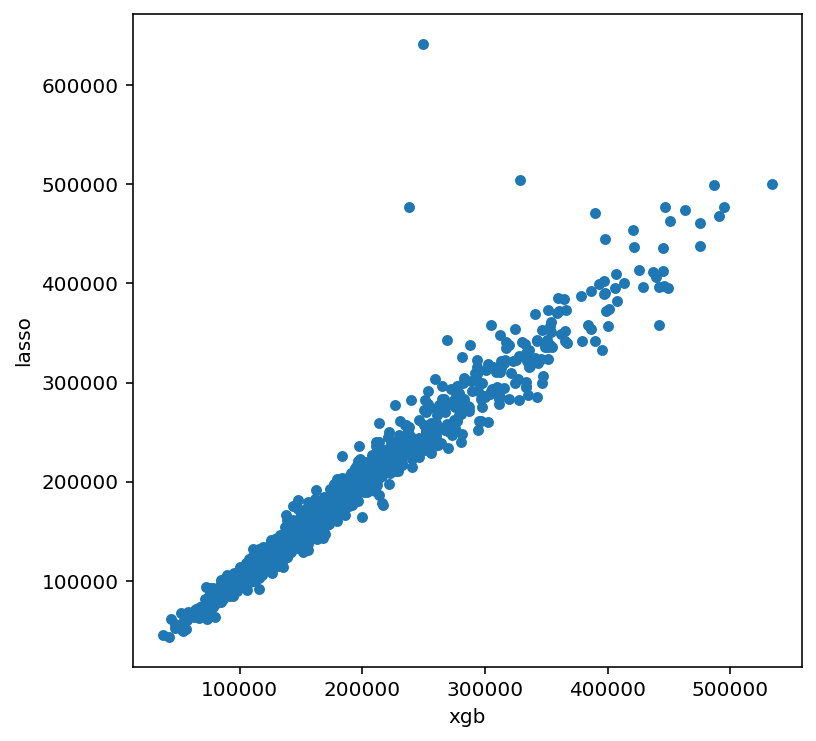

In [40]:
predictions=pd.DataFrame({"xgb":xgb_preds,"lasso":lasso_preds})
predictions.plot(x="xgb",y="lasso",kind="scatter")

多くの場合、無相関の結果の加重平均を取ることは理にかなっています-これは通常、スコアを悪化させますが、この場合はそれほど役に立ちません。

In [41]:
preds=0.7*lasso_preds + 0.3*xgb_preds

In [42]:
solution=pd.DataFrame({"id":test.Id,"SalePrice":preds})
solution.to_caaaaaaaaaaaaaaasv("ridge_sol.csv",index=False)

ケラスを試してみませんか？

フィードフォワードニューラルネットはまったくうまく機能していないようです...なぜでしょうか。

In [43]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [44]:
X_train = StandardScaler().fit_transform(X_train)

In [45]:
X_tr,X_val,y_tr,y_val=train_test_split(X_train,y,random_state=3)

In [46]:
X_tr.shape

(1095, 288)

In [47]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [48]:
model=Sequential()
model.add(Dense(1,input_dim=X_train.shape[1],W_regularizer=l1(0.001)))

model.compile(loss="mse",optimizer="adam")

C:\Users\yoshi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  


In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [50]:
hist=model.fit(X_tr,y_tr,validation_data=(X_val,y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/1
1095/1095 [==============================] - 0s 83us/step - loss: 147.0249 - val_loss: 149.9530


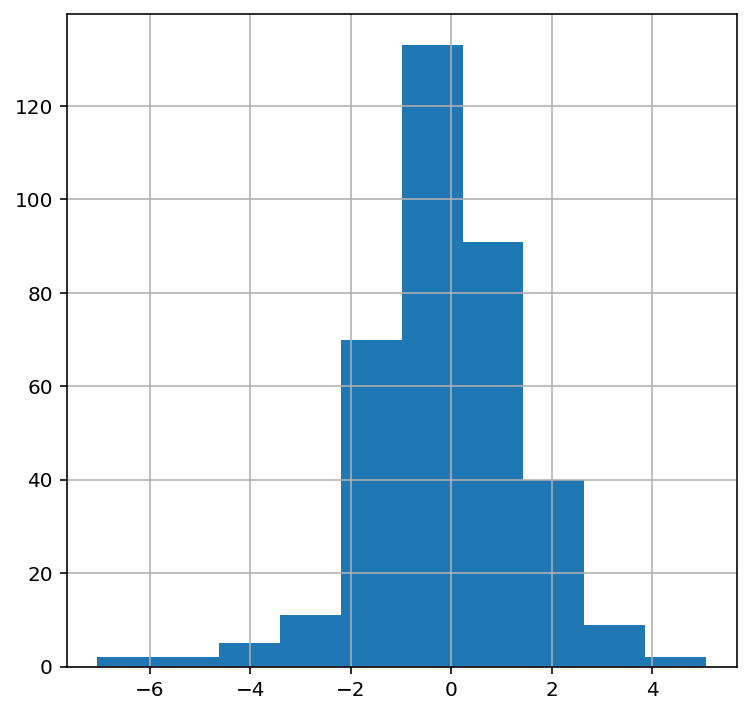

In [51]:
pd.Series(model.predict(X_val)[:,0]).hist()